In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'vit_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o /content/drive/MyDrive/dataset_19.zip

! pwd

Archive:  /content/drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflat

# Load the Data

In [4]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Testing"

# Data Distribution

In [5]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

notumor       120
glioma        120
pituitary     120
meningioma    120
dtype: int64

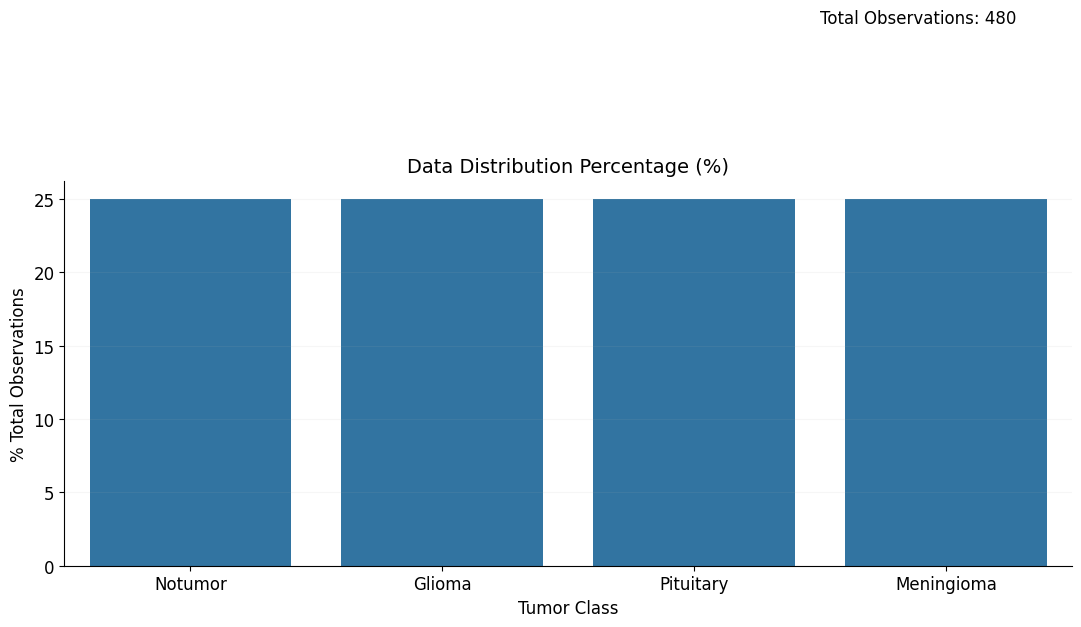

In [6]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess the Data

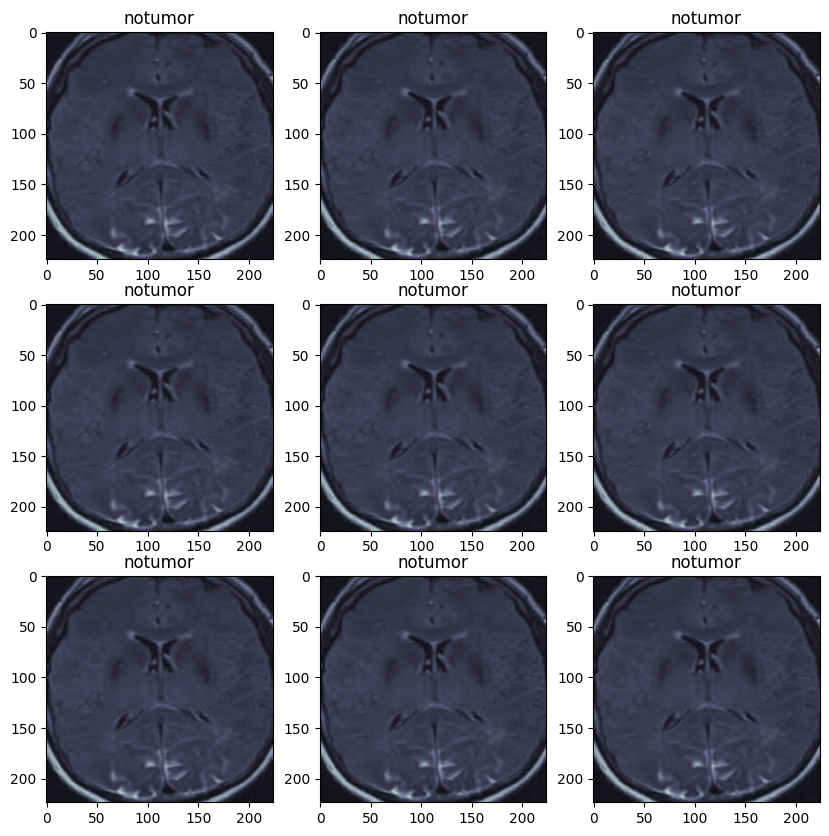

In [7]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

  # Find extreme points on the image and crop the rectangular out

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
            processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
            processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
            processed_img = cv2.resize(processed_img, (224, 224))
            cv2.imwrite(img_path, processed_img)


# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break

# Splitting the Data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


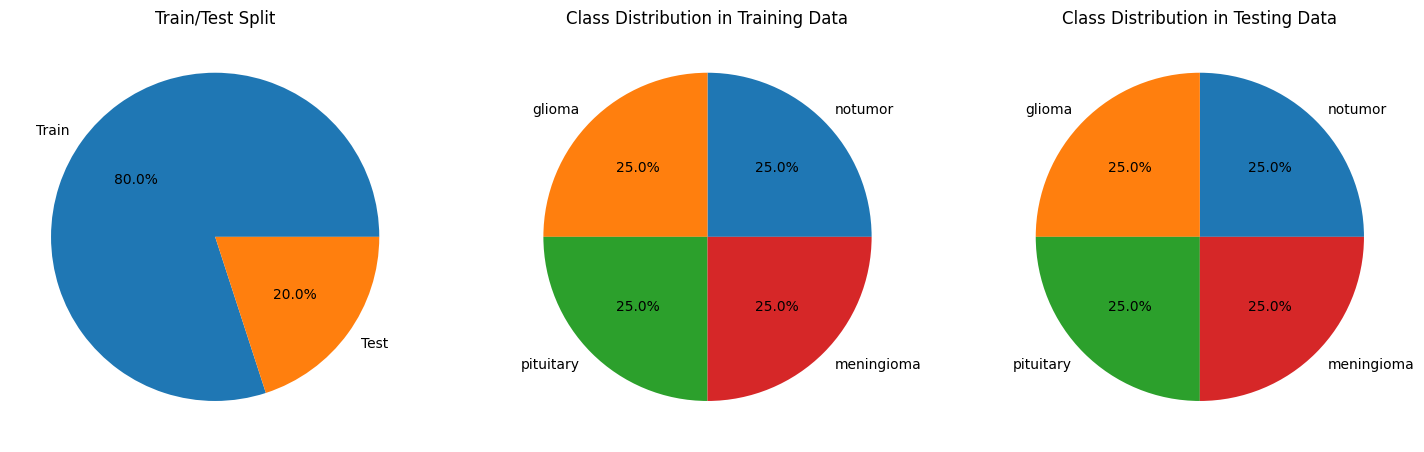

In [37]:
classes = os.listdir(dir)
batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='validation',
    shuffle = False)


print(test_generator.class_indices)

# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()

# To Check Data Loading and Augmentation


In [9]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Installing TensorFlow Addon and vit-keras Package

In [10]:
! pip install tensorflow-addons vit-keras
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.0 MB/s eta 0:00:00


# Training a Vision Transformer (ViT) model



In [29]:
from transformers import ViTForImageClassification, ViTConfig, ViTModel
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit, layers
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import optuna
from tensorflow.keras.regularizers import l2

# # Function to create ViT model
# def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate):
#     vit_model = vit.vit_b16(
#         image_size=224,
#         activation='softmax',
#         pretrained=True,
#         include_top=False,
#         pretrained_top=False,
#         classes=num_classes
#     )

#     # Unfreeze the top layers of the pretrained ViT model
#     for layer in vit_model.layers[-3:]:  # Unfreeze the last 3 layers, adjust as needed
#         layer.trainable = True

#     inputs = Input(shape=input_shape, dtype=tf.float32)
#     x = vit_model(inputs)
#     x = Dropout(dropout_rate)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss=CategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])
#     return model


## Still overfitting here ****

# def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate, unfreeze_layers):
#     vit_model = vit.vit_b16(
#         image_size=224,
#         activation='softmax',
#         pretrained=True,
#         include_top=False,
#         pretrained_top=False,
#         classes=num_classes
#     )

#     # Unfreeze layers dynamically based on Optuna's suggestion
#     for layer in vit_model.layers[-unfreeze_layers:]:
#         layer.trainable = True

#     inputs = Input(shape=input_shape)
#     x = vit_model(inputs)
#     x = BatchNormalization()(x)  # Helps in normalizing the activations from ViT
#     x = Dropout(dropout_rate)(x)
#     x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Additional dense layer
#     x = Dropout(dropout_rate)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss=CategoricalCrossentropy(from_logits=False),
#                   metrics=['accuracy'])
#     return model


## LAST TESTED PART ****

# def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate, unfreeze_layers):
#     vit_model = vit.vit_b16(
#         image_size=224,
#         activation='softmax',
#         pretrained=True,
#         include_top=False,
#         pretrained_top=False,
#         classes=num_classes
#     )

#     for layer in vit_model.layers[-unfreeze_layers:]:
#         layer.trainable = True

#     inputs = Input(shape=input_shape)
#     x = vit_model(inputs)
#     x = Dropout(dropout_rate)(x)  # Initial dropout after ViT features
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)  # Additional dropout after the dense layer
#     outputs = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=Adam(learning_rate),
#                   loss=CategoricalCrossentropy(),
#                   metrics=['accuracy'])
#     return model


# # Define the objective function for Optuna
# def objective(trial):
#     # Optuna suggests number of layers to unfreeze
#     unfreeze_layers = trial.suggest_int('unfreeze_layers', 1, 5)
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
#     dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)

#     model = create_vit_model((224, 224, 3), len(classes), learning_rate, dropout_rate, unfreeze_layers)

#     checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')  # Reduced patience
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)  # Reduced patience

#     class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
#     class_weights = {i: class_weights[i] for i in range(len(class_weights))}

#     # Run fewer epochs for initial trials
#     initial_epochs = 15

#     history = model.fit(
#         train_generator,
#         steps_per_epoch=train_generator.samples // train_generator.batch_size,
#         epochs=initial_epochs,
#         validation_data=test_generator,
#         validation_steps=test_generator.samples // test_generator.batch_size,
#         callbacks=[checkpoint, early_stopping, reduce_lr],
#         class_weight=class_weights
#     )

#     model.load_weights(model_file)
#     trial.set_user_attr('history', history.history)
#     val_loss = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=0)[0]

#     return val_loss

# # Run Optuna optimization with fewer epochs
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=10)

# # Best trial results
# print('Best trial:')
# trial = study.best_trial
# print(f'  Value: {trial.value}')
# print('  Params: ')
# for key, value in trial.params.items():
#     print(f'    {key}: {value}')

# history = trial.user_attrs['history']





## TESTING NOW

# def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate):
#     vit_model = vit.vit_b16(
#         image_size=224,
#         activation='softmax',
#         pretrained=True,
#         include_top=False,
#         pretrained_top=False,
#         classes=num_classes
#     )

#     inputs = Input(shape=input_shape)
#     x = vit_model(inputs)
#     x = Dropout(dropout_rate)(x)  # Initial dropout after ViT features
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(dropout_rate)(x)  # Additional dropout after the dense layer
#     outputs = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=Adam(learning_rate),
#                   loss=CategoricalCrossentropy(),
#                   metrics=['accuracy'])
#     return model

def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate=0.3):
    vit_model = vit.vit_b16(
        image_size=input_shape[0],  # Assuming input_shape is (height, width, channels)
        activation='softmax',
        pretrained=True,
        include_top=False,  # Ensure this is set to False if custom layers are added
        pretrained_top=False,
        classes=num_classes
    )

    inputs = Input(shape=input_shape)
    x = vit_model(inputs)

    # Check the shape of 'x' to decide on applying pooling
    if len(x.shape) == 4:  # If the output includes spatial dimensions
        x = GlobalAveragePooling2D()(x)  # Only apply if spatial dimensions are present

    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# Parameters
input_shape = (224, 224, 3)
num_classes = len(classes)  # Define the number of your classes
learning_rate = 0.0001  # Fixed learning rate
dropout_rate = 0.3  # Fixed dropout rate

# Create and train the model
model = create_vit_model(input_shape, num_classes, learning_rate, dropout_rate)

model.summary()

# Setup callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # You can adjust this based on your training need
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights
)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dense_10 (Dense)            (None, 512)               393728    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 86194436 (328.81 MB)
Trainable params: 86194436 (328.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
38/3

In [ ]:
# Extract best hyperparameters
best_learning_rate = trial.params['learning_rate']
best_dropout_rate = trial.params['dropout_rate']
best_unfreeze_layers = study.best_trial.params['unfreeze_layers']

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Create and compile the model with the best hyperparameters
model = create_vit_model((224, 224, 3), len(classes), best_learning_rate, best_dropout_rate, best_unfreeze_layers)

NameError: name 'trial' is not defined

In [ ]:
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights
)

# Save the model
model.save(model_file)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 0.8166 - accuracy: 0.9818
Epoch 1: val_loss improved from inf to 1.92440, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 529ms/step - loss: 0.8166 - accuracy: 0.9818 - val_loss: 1.9244 - val_accuracy: 0.8333 - lr: 2.7898e-04
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.7952 - accuracy: 0.9844
Epoch 2: val_loss improved from 1.92440 to 1.21813, saving model to vit_brain_mri.keras
24/24 [==============================] - 13s 528ms/step - loss: 0.7952 - accuracy: 0.9844 - val_loss: 1.2181 - val_accuracy: 0.8646 - lr: 2.7898e-04
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.9922
Epoch 3: val_loss did not improve from 1.21813
24/24 [==============================] - 9s 363ms/step - loss: 0.7400 - accuracy: 0.9922 - val_loss: 1.5406 - val_accuracy: 0.8438 - lr: 2.7898e-04
Epoch 4/100
24/24 [==============================]

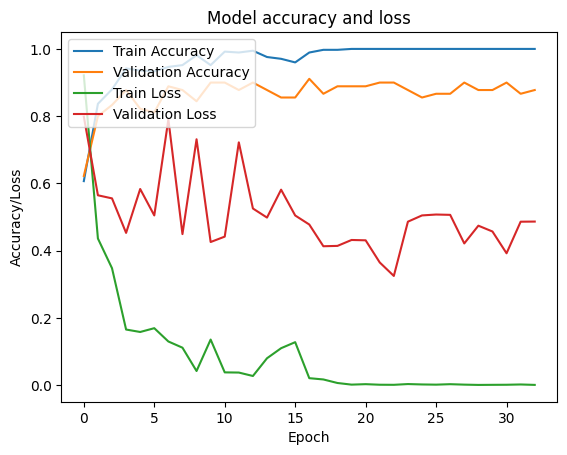

In [30]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy and loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

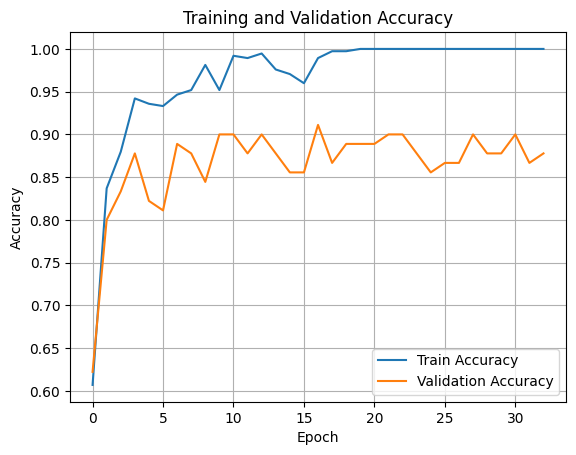

In [31]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Add a legend to specify which line is which
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot

**Model Visualisation (Evaluation)**

10/10 [==============================] - 2s 159ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 3 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 0 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 1]


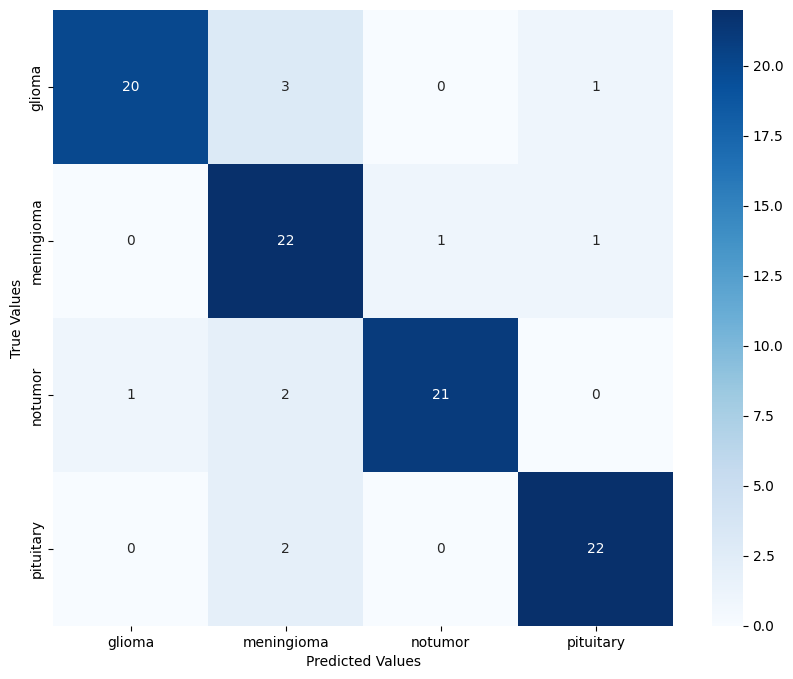

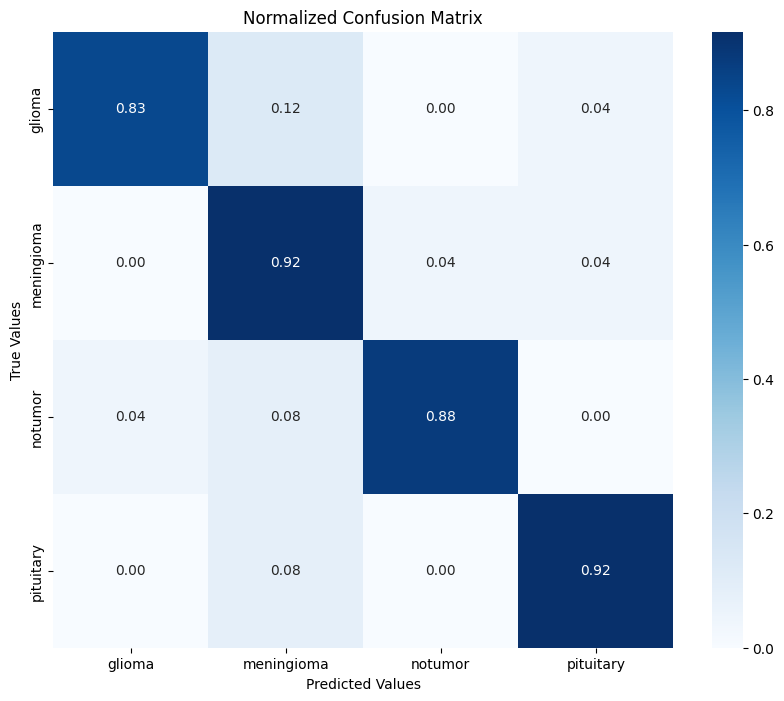

DSC: 0.887196928265427, Sensitivity: 0.8854166666666666, Specificity: 0.9618055555555556, Accuracy: 0.8854166666666666


In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")